In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Doodle Recognition/Dataset" "/content/Dataset"

Mounted at /gdrive


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import glob
import os
import matplotlib.figure
from sklearn.model_selection import train_test_split
import pandas as pd

import time
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import PIL.Image
import pathlib
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last. 
K.set_learning_phase(1) # 1 stands for learning phase

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.8/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
# Declare Variables
rows=4
cols=5
vfold_ratio=0.1, 
max_items_per_class=3000
img_size=64

In [4]:
all_files = glob.glob(os.path.join('/content/Dataset/PreprocessedData', '*.npy'))
all_files.sort()
len(all_files)

10

In [5]:
#initialize variables 
x = np.empty([0,64,64,1])
y = np.empty([0])
class_names = []
#test_label=[]
#testx=np.empty([0,784])
    #load each data file 
for idx, file in enumerate(all_files):
    data = np.load(file)
    #test = data[0:max_items_per_class, :]
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)
    x = np.concatenate((x, data), axis=0)
    #testx= np.concatenate((testx, test), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_name=class_name.split('_')[-1].split('.')[0]
    class_names.append(class_name)
data = None
labels = None
    
    #randomize the dataset 
permutation = np.random.permutation(y.shape[0])
X_train = x[permutation, :]
y = y[permutation].astype(int)

X_train.shape

(30000, 64, 64, 1)

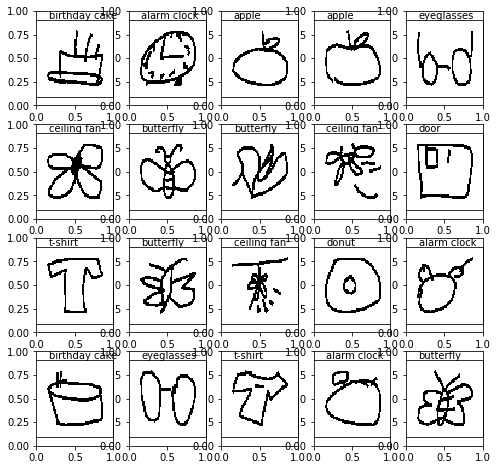

In [6]:
X_train /= 255.0
fig, axes = plt.subplots(rows,cols, figsize=(8,8))
for i in list(range(0, min(len(X_train),(rows*cols)) )):    
    #fig = matplotlib.figure.Figure()
    a = fig.add_subplot(rows,cols,i+1)
    a.text(10., -1.5, f'{class_names[y[i]]}')
    imgplot = plt.imshow(X_train[i].reshape((64,64)), interpolation='nearest',cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

In [7]:
X_train /= 255.0

In [8]:
class_names

['alarm clock',
 'apple',
 'birthday cake',
 'butterfly',
 'candle',
 'ceiling fan',
 'donut',
 'door',
 'eyeglasses',
 't-shirt']

In [9]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, len(class_names))
y.shape

(30000, 10)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.20, random_state=0)

X_train=X_train.reshape(X_train.shape[0],64,64,1)
X_test=X_test.reshape(X_test.shape[0],64,64,1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 64, 64, 1)
(6000, 64, 64, 1)
(24000, 10)
(6000, 10)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [12]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:

    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [13]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [14]:
def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [16]:
# set input image parameters
image_size = (64, 64) 
channels = 1
num_classes = 10

In [17]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [18]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_1_1_conv (Conv2D)        (None, 32, 32, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1_1_1_nb (BatchNormalizati  (None, 32, 32, 64)  256         ['conv1_1_1_conv[0][0]']         
 on)                                                                                       

In [19]:
model.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize 
    metrics=['accuracy'] # metrics to monitor
)

In [20]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

erlystop=EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0,mode='max', baseline=None)
cp_callback = ModelCheckpoint('/content/checkpoint', verbose=1, save_weights_only=True,save_freq='epoch',save_best_only=True,monitor='val_accuracy',mode='max')
rlrop = ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1,mode='max')

In [37]:
start = time.time()

modelHistory = model.fit(
    X_train,
    y_train, 
    # validation_data=norm_val_ds,
    validation_data=(X_test,y_test),
    callbacks=[cp_callback, rlrop, erlystop],
    epochs = 5,
    verbose=1)

stop = time.time()

print(f'Training took: {(stop-start)/60} minutes')

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 8.0960e-04 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.96850
750/750 [==============================] - 43s 57ms/step - loss: 8.0960e-04 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9680 - lr: 1.0000e-05
Epoch 2/15
750/750 [==============================] - ETA: 0s - loss: 7.2683e-04 - accuracy: 0.9998
Epoch 2: val_accuracy did not improve from 0.96850
750/750 [==============================] - 42s 56ms/step - loss: 7.2683e-04 - accuracy: 0.9998 - val_loss: 0.1600 - val_accuracy: 0.9678 - lr: 1.0000e-05
Epoch 3/15
750/750 [==============================] - ETA: 0s - loss: 6.8765e-04 - accuracy: 0.9999
Epoch 3: val_accuracy did not improve from 0.96850
750/750 [==============================] - 42s 56ms/step - loss: 6.8765e-04 - accuracy: 0.9999 - val_loss: 0.1700 - val_accuracy: 0.9673 - lr: 1.0000e-05
Epoch 4/15
750/750 [==============================] - ETA: 0s - loss: 5.6645e-04 - ac

In [38]:
model.evaluate(X_train, y_train)

750/750 [==============================] - 13s 17ms/step - loss: 9.5657e-05 - accuracy: 1.0000


[9.565674554323778e-05, 1.0]

In [39]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 3s 18ms/step - loss: 0.1714 - accuracy: 0.9678


[0.17139144241809845, 0.9678333401679993]

In [40]:
model.predict(X_test)

188/188 [==============================] - 3s 15ms/step


array([[3.2868057e-12, 4.1866185e-13, 1.0000000e+00, ..., 4.6024707e-13,
        1.1857041e-13, 2.1515657e-14],
       [1.3374278e-12, 1.3084100e-14, 6.0572508e-19, ..., 3.8900851e-11,
        3.0746843e-17, 1.2657604e-13],
       [2.4961385e-12, 1.6491720e-14, 1.0000000e+00, ..., 2.1538023e-15,
        5.0865425e-15, 1.1712874e-16],
       ...,
       [2.5416291e-09, 4.3518444e-12, 8.1388309e-09, ..., 1.0000000e+00,
        3.5447692e-10, 4.9456178e-10],
       [6.7863901e-09, 8.2610837e-12, 3.6746425e-11, ..., 1.2191673e-09,
        4.2800635e-10, 2.4785972e-08],
       [2.3898749e-18, 5.6753809e-22, 1.2800122e-27, ..., 1.4214893e-12,
        1.7534771e-28, 7.1723979e-18]], dtype=float32)

In [41]:
print(modelHistory.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


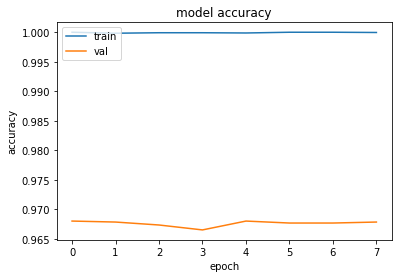

In [42]:
# summarize history for accuracy
# plt.subplot(2, 1, 1)
plt.plot(modelHistory.history['accuracy'])
plt.plot(modelHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

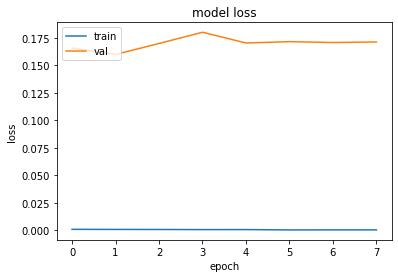

In [43]:
# summarize history for accuracy
# plt.subplot(2, 1, 1)
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
model.save('doodle_best.h5')